In [1]:
# import the necessary packages
import argparse
import math

from imutils.perspective import four_point_transform, order_points
from matplotlib import pyplot as plt
from imutils import contours
import imutils
import cv2
import numpy as np


In [2]:
def show_img(img, size=3, title=None):
    fig = plt.gcf()
    fig.set_size_inches(size, size)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

In [3]:
def draw_points(cnt, img, color):
    for p in cnt:
        p = tuple(p)
        cv2.circle(img, p, 3, color, -1)


In [4]:
def sort_contours_bound_rect(cnts, reverse=False):
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][2] * b[1][3], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return cnts, boundingBoxes


In [5]:
# define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITS_LOOKUP = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 0, 1, 0, 0, 1, 0): 1,
    (1, 0, 1, 1, 1, 0, 1): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 1, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9
}


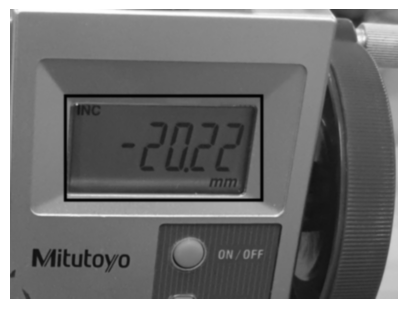

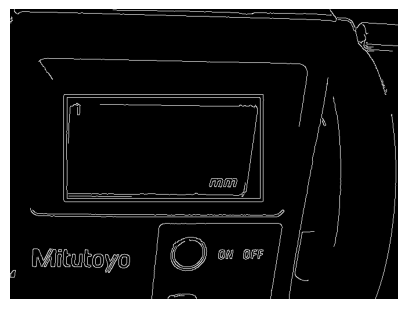

In [28]:
# load the example image
# image = cv2.imread("./example/recognize-digits-master/example.jpg")
# image = cv2.imread("./text_window_ad.jpg")
image = cv2.imread("./20.jpg")

# image = cv2.imread("./manually_cropped/mancrop_25.jpg")

# image = cv2.imread("./example/recognize-digits-master/example.jpg")
# image = cv2.imread("./sipa0images/5/2.jpg")
# image = cv2.imread("./example/recognize-digits-master/calculator3.jpg")

# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 200, 255)

show_img(blurred, 5, )
show_img(edged, 5)

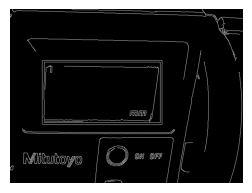

In [29]:
show_img(edged)

In [30]:
# find contours in the edge map, then sort them by their size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Sort the contours by area ensuring largest area is at the front of the list
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None

# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if the contour has four vertices, then it is likely the LCD display is located
	if len(approx) == 4:
		displayCnt = approx
		break

In [31]:
displayCnt

array([[[ 93, 147]],

       [[ 93, 331]],

       [[436, 331]],

       [[436, 147]]], dtype=int32)

In [32]:

# extract the thermostat display, apply a perspective transform to it
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(gray, displayCnt.reshape(4, 2))



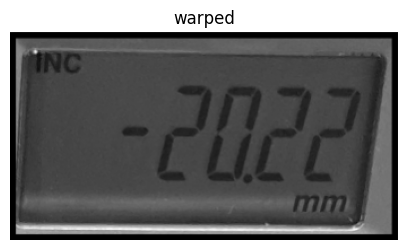

In [33]:
show_img(warped, 5, "warped")

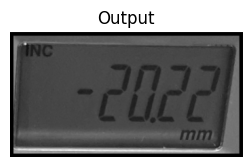

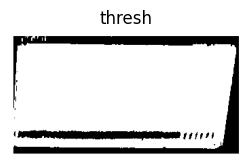

In [34]:

# Recognising the Digits
# threshold the warped image, then apply a series of morphological operations to cleanup the thresholded image

thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)



show_img(output, title="Output")
show_img(thresh, title="thresh")

In [35]:
# find contours in the thresholded image, then initialize the
# digit contours lists
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
# loop over the digit area candidates
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# if the contour is sufficiently large, it must be a digit
	if w >= 15 and (h >= 30 and h <= 40):
		digitCnts.append(c)

In [36]:
print(len(digitCnts))

0


In [25]:
# sort the contours from left-to-right, then initialize the
# actual digits themselves
digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
digits = []

In [50]:
print(len(digitCnts))
# print(digitCnts)

3


AD


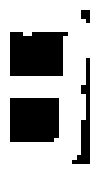

AD


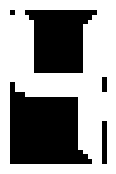

AD


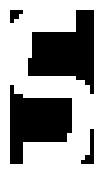

In [26]:
# loop over each of the digits
for c in digitCnts:
	print("AD")
	# extract the digit ROI
	(x, y, w, h) = cv2.boundingRect(c)
	roi = thresh[y:y + h, x:x + w]
	show_img(roi, 2)
	# compute the width and height of each of the 7 segments that are being examined
	(roiH, roiW) = roi.shape
	(dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
	dHC = int(roiH * 0.05)
	# define the set of 7 segments
	segments = [
		((0, 0), (w, dH)),	# top
		((0, 0), (dW, h // 2)),	# top-left
		((w - dW, 0), (w, h // 2)),	# top-right
		((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
		((0, h // 2), (dW, h)),	# bottom-left
		((w - dW, h // 2), (w, h)),	# bottom-right
		((0, h - dH), (w, h))	# bottom
	]
	on = [0] * len(segments)

	# loop over the segments

	for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
		# extract the segment ROI, count the total number of
		# thresholded pixels in the segment, and then compute
		# the area of the segment
		segROI = roi[yA:yB, xA:xB]
		total = cv2.countNonZero(segROI)
		area = (xB - xA) * (yB - yA)
		# if the total number of non-zero pixels is greater than
		# 50% of the area, mark the segment as "on"
		if total / float(area) > 0.5:
			on[i]= 1
	# lookup the digit and draw it on the image
	digit = DIGITS_LOOKUP[tuple(on)]
	digits.append(digit)
	cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
	cv2.putText(output, str(digit), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)


# show_img(roi)
# print(len(segments))

In [41]:
print(segments)

[((0, 0), (19, 5)), ((0, 0), (4, 17)), ((15, 0), (19, 17)), ((0, 16), (19, 18)), ((0, 17), (4, 35)), ((15, 17), (19, 35)), ((0, 30), (19, 35))]


[3, 4, 5]


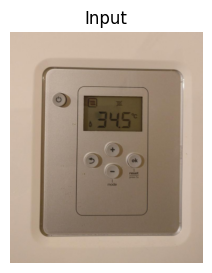

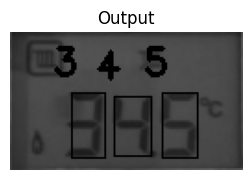

In [27]:
# display the digits
# print(u"{}{}.{} \u00b0C".format(*digits))
print(digits)
show_img(image, title="Input")
show_img(output, title="Output")
